## Analyzing Ocean Color Imagery

From September 13th cruise on the R/V Shearwater

All ocean color measurements taken manually off the bow using Micasense RedEdge

### Import Shearwater Data

Use pandas library to read the csv

In [1]:
import pandas as pd
df = pd.read_csv("data/130920_shearwatergulf_rededge/Data every 1 min_001.csv")
df.head()

,Date,Time,SW-ZDA-Year,SW-ZDA-Month,SW-ZDA-Day,SW-ZDA-Time,SW-GGA-Lat,SW-GGA-NorS,SW-GGA-Long,SW-GGA-EorW,...,SW-Weather-HumidRel-%,SW-Wind-WindSpeedRel,SW-Wind-WindAngleRel,TrueWind-DRV-SPEED,TrueWind-DRV-DIRECTION,TSG--temp-SBE38,TSG--sal,SW-Depth-DBT-Depth below transducer (m),DepthOverall-DRV-VALUE,Unnamed: 24
0,09/13/2020,11:47:46,2020,9,13,114907.70,3443.0548,N,7640.2341,W,...,89.4,9.39,26.4,9.38,40.19,26.8799,16.5905,5.50,6.50,NaN
1,09/13/2020,11:48:46,2020,9,13,115007.70,3443.0549,N,7640.2341,W,...,89.5,9.99,22.1,9.99,35.71,26.8796,16.5906,5.48,6.48,NaN
2,09/13/2020,11:49:46,2020,9,13,115107.69,3443.0549,N,7640.2341,W,...,89.4,12.79,17.4,13.08,30.48,26.8796,16.5906,5.48,6.48,NaN
3,09/13/2020,11:50:46,2020,9,13,115207.70,3443.0548,N,7640.2338,W,...,89.3,11.39,23.1,11.39,36.70,26.8793,16.5686,5.47,6.47,NaN
4,09/13/2020,11:51:46,2020,9,13,115308.00,3443.0547,N,7640.2339,W,...,89.1,13.39,18.9,13.40,32.57,26.8791,16.5677,5.47,6.47,NaN


Fix the date and time to be a python datetime object for easier plotting

In [2]:
from datetime import datetime

date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]

Convert the dms-ish format to decimal degrees

In [3]:
import numpy as np

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

Convert pandas dataframe to geodataframe with geospatial data incorporated

<AxesSubplot:>

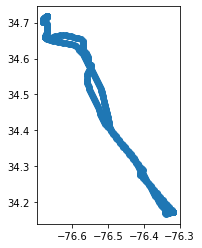

In [4]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.plot()

It is coarse but let's plot it with coastline included from geopandas

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


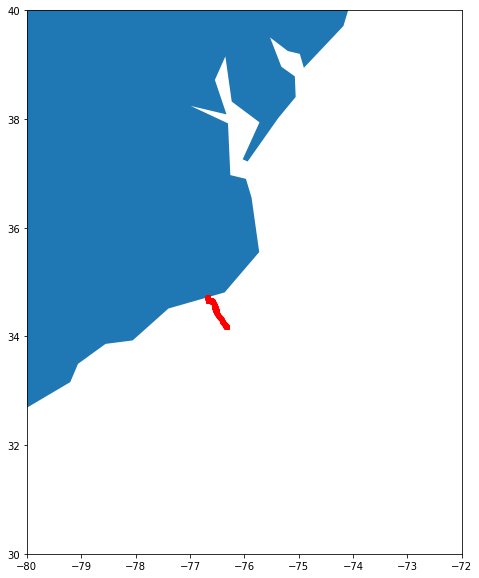

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(10, 6), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

ax.set_xlim(-80, -72)
ax.set_ylim(30, 40)

fig.show()

<AxesSubplot:xlabel='lon', ylabel='lat'>

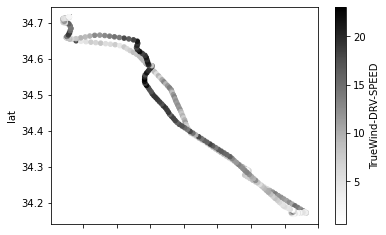

In [6]:
df.plot(kind='scatter',x='lon', y='lat', c='TrueWind-DRV-SPEED', cmap='Greys')

<AxesSubplot:xlabel='lon', ylabel='lat'>

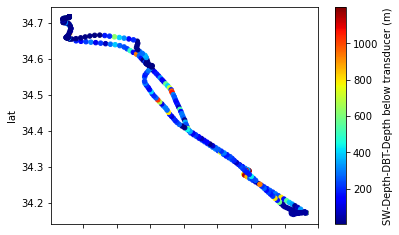

In [7]:
df.plot(kind='scatter',x='lon', y='lat', c='SW-Depth-DBT-Depth below transducer (m)', cmap='jet')

### UAS Ocean Color Data

Read in uas data which was saved as an ESRI shapefile that can be read with geopandas 

In [67]:
chla_gdf = gpd.read_file('uas_data_0014.shp')
chla_gdf.time = pd.to_datetime(chla_gdf.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf.spectra = chla_gdf.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
chla_gdf.head()

,chla,Latitude,Longitude,spectra,time,geometry
0,0.063871,34.247825,-76.384614,"[0.02200393, 0.00789785, 0.00113606, 0.0007810...",2020-09-13 16:33:28,POINT (-76.38461 34.24782)
1,0.063328,34.272481,-76.398839,"[0.02668011, 0.01040405, 0.00151097, 0.0012178...",2020-09-13 16:37:58,POINT (-76.39884 34.27248)
2,0.246177,34.303667,-76.416853,"[0.03596776, 0.01744403, 0.00180694, 0.0011806...",2020-09-13 16:43:35,POINT (-76.41685 34.30367)
3,0.088147,34.253064,-76.387614,"[0.02093576, 0.00810775, 0.00116406, 0.0008980...",2020-09-13 16:34:27,POINT (-76.38761 34.25306)
4,0.321401,34.297428,-76.413183,"[0.03313249, 0.01624155, 0.00177827, 0.0010865...",2020-09-13 16:42:29,POINT (-76.41318 34.29743)


In [68]:
chla_gdf2 = gpd.read_file('uas_data_0012.shp')
chla_gdf2.time = pd.to_datetime(chla_gdf2.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf2.spectra = chla_gdf2.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
chla_gdf2.head()

,chla,Latitude,Longitude,spectra,time,geometry
0,0.084945,34.282014,-76.408947,"[0.02896204, 0.01197021, 0.00103042, 0.0005870...",2020-09-13 15:16:34,POINT (-76.40895 34.28201)
1,0.461703,34.289567,-76.408244,"[0.03581515, 0.02013321, 0.00228888, 0.0014058...",2020-09-13 15:12:36,POINT (-76.40824 34.28957)
2,0.419592,34.290581,-76.406967,"[0.03543637, 0.01893663, 0.00181198, 0.0011855...",2020-09-13 15:11:51,POINT (-76.40697 34.29058)
3,0.435817,34.290833,-76.406636,"[0.03500701, 0.01909028, 0.00213409, 0.0011644...",2020-09-13 15:11:39,POINT (-76.40664 34.29083)
4,0.097944,34.283056,-76.408336,"[0.0291852, , 0.01228695, 0.00079539, 0.000370...",2020-09-13 15:15:55,POINT (-76.40834 34.28306)


In [69]:
chla_gdf3 = gpd.read_file('uas_data_0005.shp')
chla_gdf3.time = pd.to_datetime(chla_gdf3.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf3.spectra = chla_gdf3.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
chla_gdf3.head()

,chla,Latitude,Longitude,spectra,time,geometry
0,6.099412,34.586856,-76.555336,"[0.02999167, 0.04515203, 0.01194982, 0.0050126...",2020-09-13 14:09:19,POINT (-76.55534 34.58686)
1,7.363885,34.585728,-76.554025,"[0.04894378, 0.07789224, 0.04111039, 0.0312854...",2020-09-13 14:11:12,POINT (-76.55402 34.58573)
2,6.587307,34.585536,-76.553925,"[0.05387808, 0.08298596, 0.04735034, 0.0370990...",2020-09-13 14:11:20,POINT (-76.55392 34.58554)
3,11.328415,34.586717,-76.555253,"[0.02141596, 0.03853804, 0.01059423, 0.0032117...",2020-09-13 14:09:33,POINT (-76.55525 34.58672)
4,5.388796,34.586628,-76.555203,"[0.03152826, 0.04573177, 0.0150598, , 0.009890...",2020-09-13 14:09:42,POINT (-76.55520 34.58663)


In [70]:
chla_gdf4 = gpd.read_file('uas_data_0013.shp')
chla_gdf4.time = pd.to_datetime(chla_gdf4.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf4.spectra = chla_gdf4.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
chla_gdf4.head()

,chla,Latitude,Longitude,spectra,time,geometry
0,0.014084,34.173711,-76.320475,"[0.02429609, 0.00547031, 0.00084035, 0.0006794...",2020-09-13 15:56:31,POINT (-76.32048 34.17371)
1,0.012786,34.173703,-76.320442,"[0.02655954, 0.00638652, 0.00084762, 0.0007028...",2020-09-13 15:56:25,POINT (-76.32044 34.17370)
2,0.012191,34.173758,-76.320539,"[0.02736388, 0.00703582, 0.0015577, , 0.001158...",2020-09-13 15:56:52,POINT (-76.32054 34.17376)
3,0.014467,34.173689,-76.320403,"[0.02518396, 0.00614233, 0.00117491, 0.0009190...",2020-09-13 15:56:17,POINT (-76.32040 34.17369)


<AxesSubplot:>

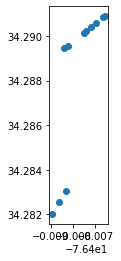

In [71]:
chla_gdf2.plot()

In [72]:
chla_gdf = chla_gdf.append(chla_gdf2, ignore_index=True)
chla_gdf = chla_gdf.append(chla_gdf3, ignore_index=True)
chla_gdf = chla_gdf.append(chla_gdf4, ignore_index=True)

<AxesSubplot:>

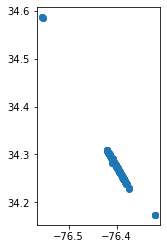

In [76]:
chla_gdf.plot()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


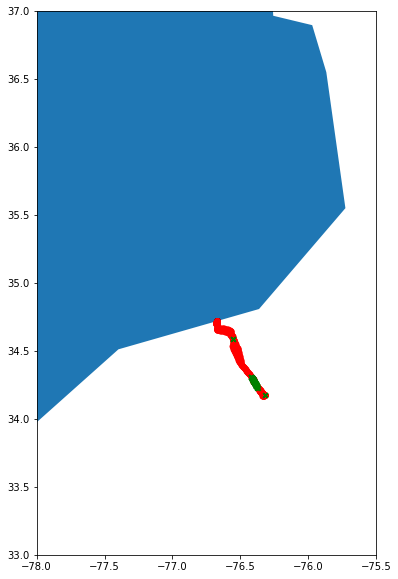

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(10, 6), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=25)
chla_gdf.plot(ax=ax, marker='x', color='green', markersize=20)

ax.set_xlim(-78, -75.5)
ax.set_ylim(33, 37)

fig.show()

,chla,Latitude,Longitude,spectra,time,geometry
191,6.099412,34.586856,-76.555336,"[0.02999167, 0.04515203, 0.01194982, 0.0050126...",2020-09-13 14:09:19,POINT (-76.55534 34.58686)
194,11.328415,34.586717,-76.555253,"[0.02141596, 0.03853804, 0.01059423, 0.0032117...",2020-09-13 14:09:33,POINT (-76.55525 34.58672)
195,5.388796,34.586628,-76.555203,"[0.03152826, 0.04573177, 0.0150598, , 0.009890...",2020-09-13 14:09:42,POINT (-76.55520 34.58663)
192,7.363885,34.585728,-76.554025,"[0.04894378, 0.07789224, 0.04111039, 0.0312854...",2020-09-13 14:11:12,POINT (-76.55402 34.58573)
193,6.587307,34.585536,-76.553925,"[0.05387808, 0.08298596, 0.04735034, 0.0370990...",2020-09-13 14:11:20,POINT (-76.55392 34.58554)
...,...,...,...,...,...,...
112,0.406780,34.308592,-76.419706,"[0.03464214, 0.01820469, 0.0019673, , 0.001504...",2020-09-13 16:44:30,POINT (-76.41971 34.30859)
111,0.437119,34.308792,-76.419831,"[0.0322323, , 0.01760503, 0.00185136, 0.000963...",2020-09-13 16:44:32,POINT (-76.41983 34.30879)
98,0.382371,34.309386,-76.420172,"[0.03692629, 0.01875788, 0.00203518, 0.0012303...",2020-09-13 16:44:38,POINT (-76.42017 34.30939)
163,0.381028,34.309889,-76.420439,"[0.03635446, 0.01843146, 0.0020137, , 0.001094...",2020-09-13 16:44:43,POINT (-76.42044 34.30989)


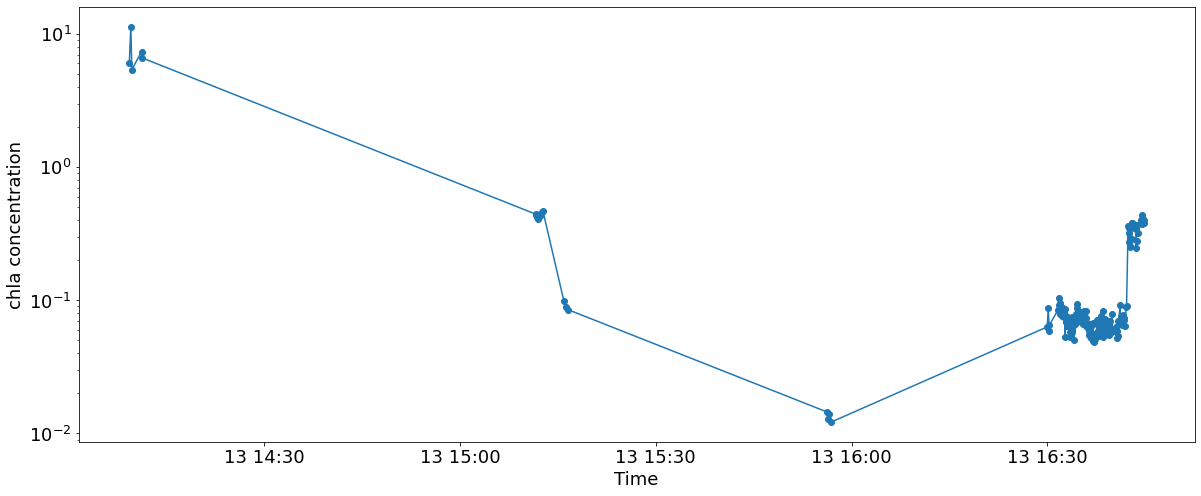

In [154]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(20, 8))

ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
#ax.set_ylim(-1,12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
ax.set_yscale('log')
plt.savefig('chlaall.png')

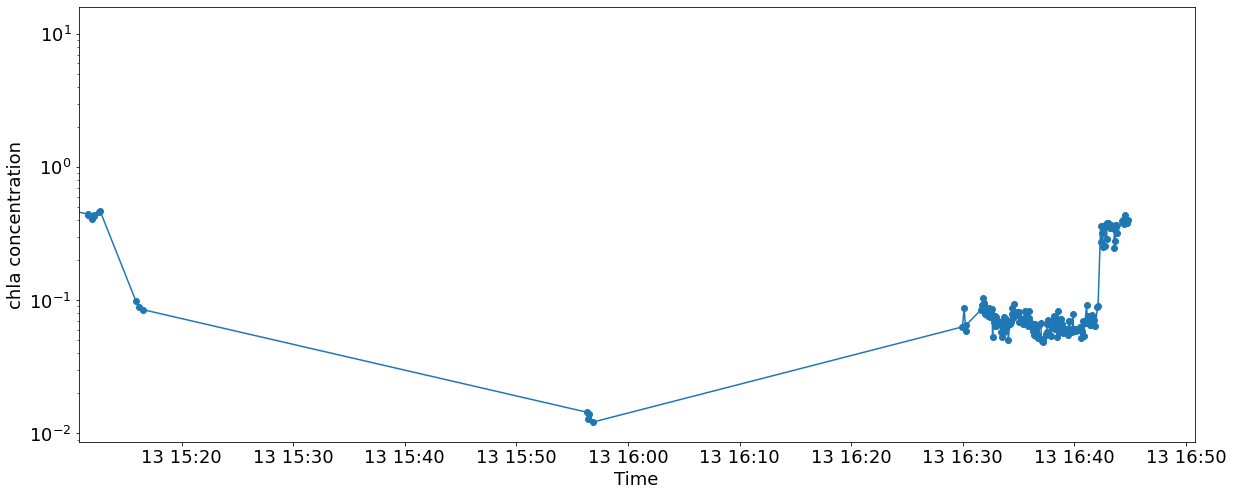

In [152]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.set_xlim(datetime.strptime('2020-09-13 15:10:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:50:46', '%Y-%m-%d %H:%M:%S'))


ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
#ax.set_ylim(-1,12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
ax.set_yscale('log')

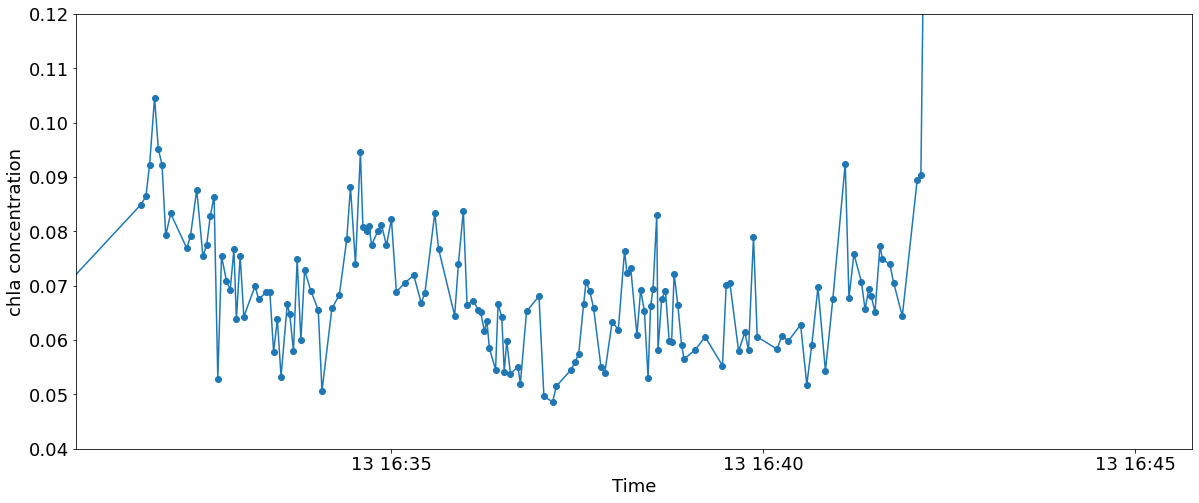

In [166]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.set_xlim(datetime.strptime('2020-09-13 16:30:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:45:46', '%Y-%m-%d %H:%M:%S'))


ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
ax.set_ylim(0.04,0.12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
#ax.set_yscale('log')
plt.savefig('chlzoom.png')

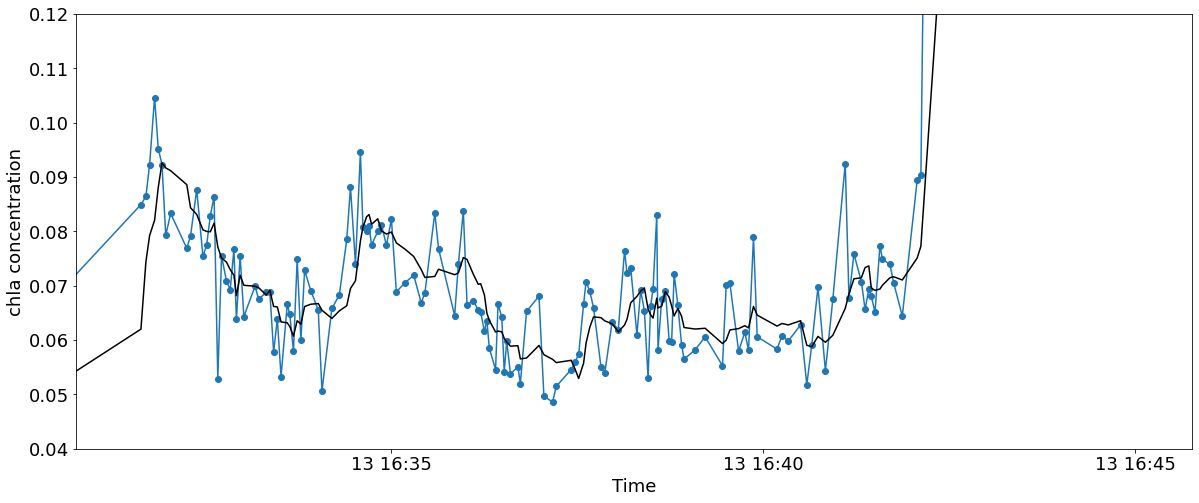

In [176]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.set_xlim(datetime.strptime('2020-09-13 16:30:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:45:46', '%Y-%m-%d %H:%M:%S'))


ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla.rolling(window=6).mean(), color='black')
ax.set_ylim(0.04,0.12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
#ax.set_yscale('log')
plt.savefig('chlzoom.png')

In [167]:
df.rolling(window=5).mean()

fig, ax = plt.subplots(figsize=(20, 8))

ax.set_xlim(datetime.strptime('2020-09-13 16:30:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:45:46', '%Y-%m-%d %H:%M:%S'))


ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
#ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla.rolling(window=5).mean())
ax.set_ylim(0.04,0.12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
#ax.set_yscale('log')
#plt.savefig('chlzoom.png')

IndexError: list assignment index out of range

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


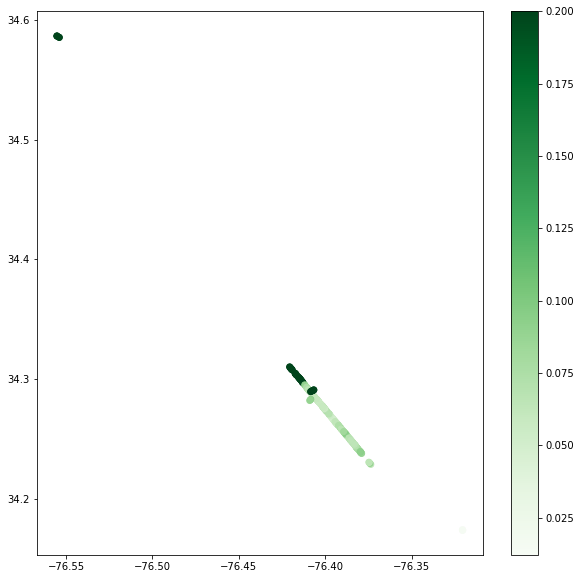

In [126]:
fig, ax = plt.subplots(figsize=(10, 10))

sc = ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=.2)
fig.colorbar(sc)
fig.show()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  after removing the cwd from sys.path.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


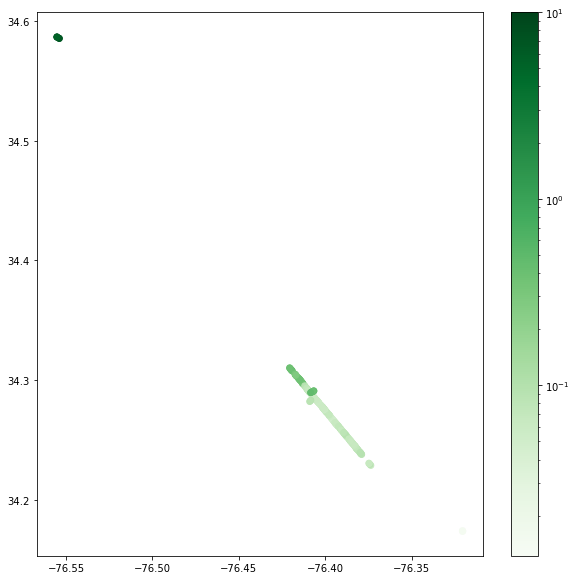

In [91]:
import matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

sc = ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=10, norm=matplotlib.colors.LogNorm())
fig.colorbar(sc)
fig.show()

### Plot them together

<AxesSubplot:>

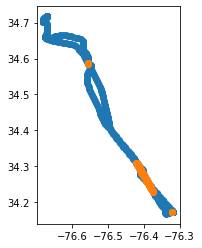

In [127]:
fig, ax = plt.subplots()

gdf.plot(ax=ax)
chla_gdf.plot(ax=ax)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


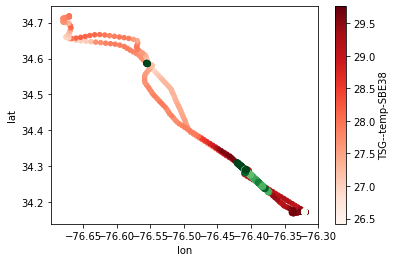

In [128]:
fig, ax = plt.subplots()
df.plot(kind='scatter',x='lon', y='lat', c='TSG--temp-SBE38', cmap='Reds',ax=ax)
ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=0.1)
fig.show()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


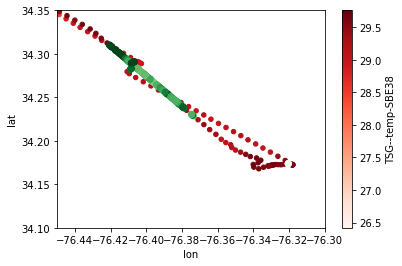

In [133]:
fig, ax = plt.subplots()
df.plot(kind='scatter',x='lon', y='lat', c='TSG--temp-SBE38', cmap='Reds',ax=ax)
ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=0.1)
ax.set_ylim(34.1,34.35)
ax.set_xlim(-76.45,-76.30)
fig.show()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


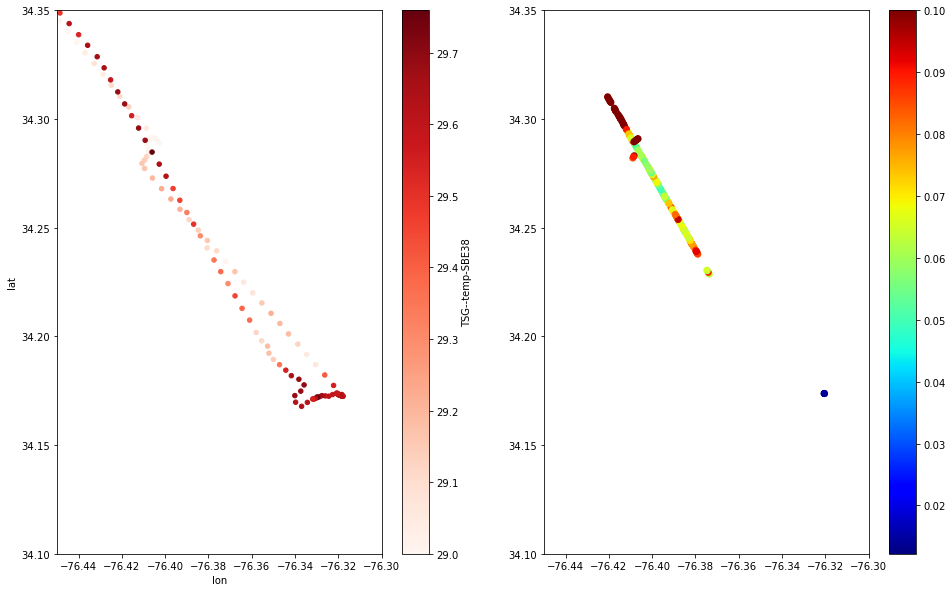

In [148]:
fig, ax = plt.subplots(1,2, figsize=(16,10))
df.plot(kind='scatter',x='lon', y='lat', c='TSG--temp-SBE38', cmap='Reds',ax=ax[0], vmin=29)
sc = ax[1].scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='jet', vmax=0.1)
fig.colorbar(sc)
ax[0].set_ylim(34.1,34.35)
ax[0].set_xlim(-76.45,-76.30)
ax[1].set_ylim(34.1,34.35)
ax[1].set_xlim(-76.45,-76.30)
plt.savefig('chlvssst.png')
fig.show()

#### Plot chl-a against S and T from the Shearwater

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


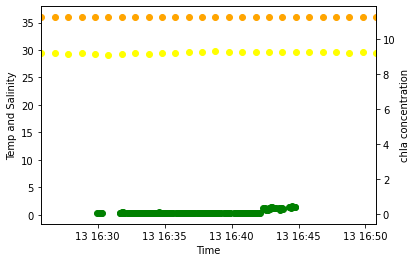

In [129]:
fig, ax = plt.subplots()

ax.set_xlim(datetime.strptime('2020-09-13 16:25:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:50:46', '%Y-%m-%d %H:%M:%S'))

ax2 = ax.twinx()
ax.set_ylabel('Temp and Salinity')
ax.set_xlabel('Time')
ax2.set_ylabel('chla concentration')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--temp-SBE38'], color='yellow')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--sal'], color='orange')
ax2.scatter(x=chla_gdf['time'], y=chla_gdf['chla'], color='green')
fig.show()


/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


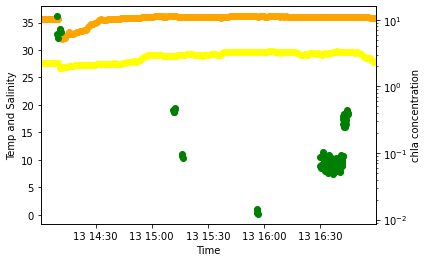

In [99]:
fig, ax = plt.subplots()

ax.set_xlim(datetime.strptime('2020-09-13 14:00:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:59:46', '%Y-%m-%d %H:%M:%S'))

ax2 = ax.twinx()
ax.set_ylabel('Temp and Salinity')
ax.set_xlabel('Time')
ax2.set_ylabel('chla concentration')
ax2.set_yscale('log')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--temp-SBE38'], color='yellow')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--sal'], color='orange')
ax2.scatter(x=chla_gdf['time'], y=chla_gdf['chla'], color='green')
fig.show()


In [192]:
chla_gdf.spectra.values

array([list(['0.02200393', '0.00789785', '0.00113606', '0.00078107', '0.00072814']),
       list(['0.02668011', '0.01040405', '0.00151097', '0.00121781', '0.00146622']),
       list(['0.03596776', '0.01744403', '0.00180694', '0.00118068', '0.0013282', '']),
       list(['0.02093576', '0.00810775', '0.00116406', '0.00089808', '0.00116452']),
       list(['0.03313249', '0.01624155', '0.00177827', '0.00108651', '0.00120601']),
       list(['0.03258913', '0.01424824', '0.00167678', '0.00116578', '0.00147281']),
       list(['0.01953409', '0.0067388', '', '0.0008794', '', '0.00065381', '0.00088336']),
       list(['0.03147974', '0.01532142', '0.00186861', '0.00116014', '0.00122541']),
       list(['0.02872116', '0.01115625', '0.001361', '', '', '0.00098762', '0.00122088']),
       list(['0.02812097', '0.01093312', '0.00132842', '0.00094661', '0.00118423']),
       list(['0.02496985', '0.00888755', '0.00081982', '0.00063116', '0.00086274']),
       list(['0.03102751', '0.01291972', '0.001901

In [194]:
spectra = []
for strl in chla_gdf.spectra.values:
    spec = []
    for i in strl:
        if i != '':
            spec.append(float(i))
    spectra.append(spec)
np.array(spectra).shape

(200, 5)

In [195]:
spectra = np.array(spectra)

### Clustering Spectra

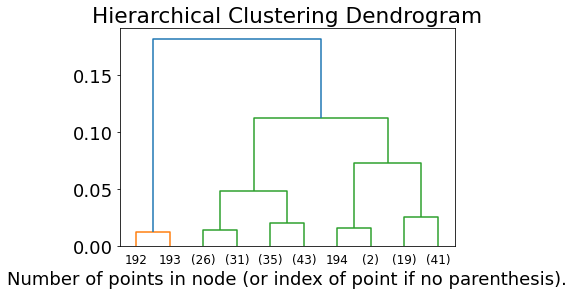

In [217]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(spectra)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [236]:
model = AgglomerativeClustering(n_clusters=4).fit(spectra)

In [237]:
np.unique(model.labels_, return_counts=True)


(array([0, 1, 2, 3]), array([135,   3,  60,   2]))

In [238]:
colors = []
for lab in model.labels_:
    if lab == 0:
        colors.append('red')
    elif lab == 1:
        colors.append('green')
    elif lab == 2:
        colors.append('blue')
    elif lab == 3:
        colors.append('black')
    elif lab == 4:
        colors.append('purple')

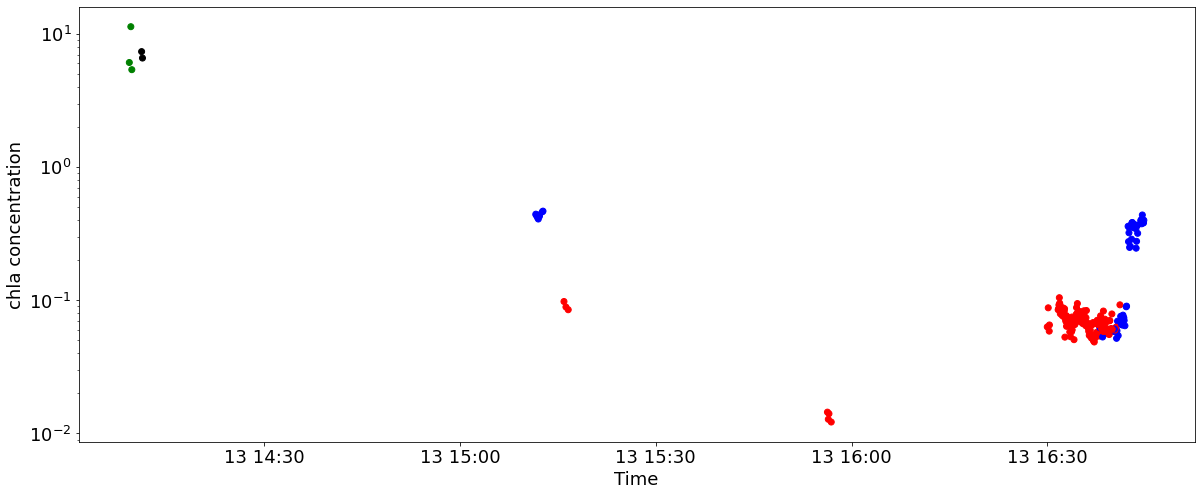

In [239]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(20, 8))

ax.scatter(chla_gdf.time, chla_gdf.chla, color=colors)
#ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
#ax.set_ylim(-1,12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
ax.set_yscale('log')

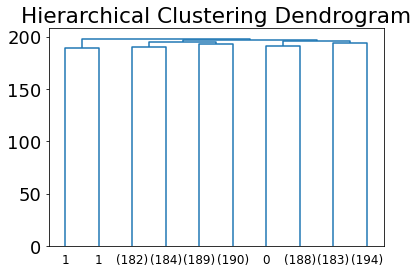

In [257]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
ddr = None
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, truncate_mode='level', p=3, **kwargs)


iris = load_iris()
x = iris.data[:20]
model = AgglomerativeClustering(n_clusters=3)

model = model.fit(spectra)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)
plt.show()

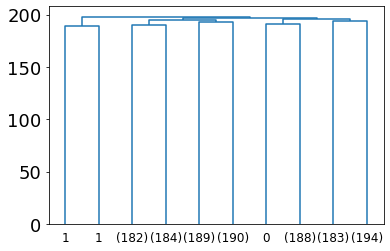

In [256]:
# Children of hierarchical clustering
children = model.children_

# Distances between each pair of children
# Since we don't have this information, we can use a uniform one for plotting
distance = np.arange(children.shape[0])

# The number of observations contained in each cluster level
no_of_observations = np.arange(2, children.shape[0]+2)

# Create linkage matrix and then plot the dendrogram
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

# Plot the corresponding dendrogram
ddr = dendrogram(linkage_matrix, labels=model.labels_, truncate_mode='level', p=3)

In [252]:
ddr.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])